## Connect with Drive

In [0]:
from google.colab import drive
drive.mount("/betogaona7")

In [0]:
%cd ./../betogaona7/My\ Drive/app/Distracted

## Imports 

In [0]:
import os 
import random
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf


## Create a TFRecord file

In [0]:
def imgs_with_labels(src):
  data = []
  total = 0
  for path, subdir, files in os.walk(src):
    for file in files:
      if file[-3:] == 'jpg': 
        data.append((os.path.join(path, file), path[-1:]))
      total += 1
  return data, total

data, total = imgs_with_labels("./data/train/")

In [0]:
img_path, label = data[random.randint(0, total)]
print("img: ", img_path, " label: ", label, " total: ", total )

img:  ./data/train/c7/img_34589.jpg  label:  7  total:  22424


In [0]:
def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

tfr_name = "train.tfrecord"
writer = tf.python_io.TFRecordWriter(tfr_name)

for img_path, img_class in data:
  img = np.array(Image.open(img_path))
  
  img_raw = open(img_path, 'rb').read()
  label = int(img_class)
  path = str.encode(img_path)
  
  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(img_raw),
      'label': _int64_feature(label),
      'height': _int64_feature(img.shape[0]),
      'width': _int64_feature(img.shape[1]),
      'depth': _int64_feature(img.shape[2]),
      'path': _bytes_feature(path) }))
  writer.write(example.SerializeToString())
writer.close()

In [0]:
for example in tf.python_io.tf_record_iterator("train.tfrecord"):
  result = tf.train.Example.FromString(example)
print(result)

In [0]:
!du -lh train.tfrecord
!du -sh ./data/train/

911M	train.tfrecord
913M	./data/train/


## Build dataset 

In [0]:
def StateFarmDataset(image_size, tfrecord_file, shuffle_buffer_size, batch_size):
  img_size = tf.cast(image_size, tf.int32)
  
  def _parse_function(example):
    features = {'label': tf.FixedLenFeature((), tf.int64),
                'image': tf.FixedLenFeature((), tf.string),
                'height': tf.FixedLenFeature((), tf.int64),
                'width': tf.FixedLenFeature((), tf.int64),
                'depth': tf.FixedLenFeature((), tf.int64),
                'path': tf.FixedLenFeature((), tf.string)}
    parsed_features = tf.parse_single_example(example, features)
    
    # Reconstruct image 
    image = tf.image.decode_jpeg(parsed_features['image'], 3)
    img_shape = tf.stack([tf.cast(parsed_features['height'], tf.int32),
                          tf.cast(parsed_features['width'], tf.int32),
                          tf.cast(parsed_features['depth'], tf.int32)])
    image = tf.reshape(image, img_shape)
    
    # Normalize the image in the range 0 to 1
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Reshape image 
    image = tf.image.resize(image, [image_size, image_size])
        
    # One-hot encoding
    label = tf.one_hot(parsed_features['label'], 10)
    
    return image, label, parsed_features['path']
  
  dataset = tf.data.TFRecordDataset(tfrecord_file)
  dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.map(_parse_function)
  
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(1)
  
  return dataset         

In [37]:
total = 22424
dataset = StateFarmDataset(64, "train.tfrecord", total, 1)
print(dataset)

<DatasetV1Adapter shapes: ((?, 64, 64, ?), (?, 10), (?,)), types: (tf.float32, tf.float32, tf.string)>


Label:  [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Img path:  [b'./data/train/c7/img_41597.jpg']
Img shape:  (1, 64, 64, 3)


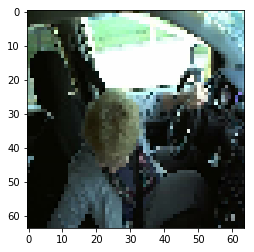

In [38]:
iterator = dataset.make_one_shot_iterator()
record = iterator.get_next()
with tf.Session() as sess:
  img, label, img_path = sess.run(record)
  print("Label: ", label)
  print("Img path: ", img_path)
  print("Img shape: ", img.shape)
  #print(img)
  plt.imshow(img[0])

In [27]:
total = 22424
tsize = int(0.90*total)
vsize = int(0.10*total)
batch_size = 128

dataset = StateFarmDataset(64, "train.tfrecord", total, batch_size)

train_data = dataset.take(tsize)
valid_data = dataset.skip(vsize)

train_iterator = train_data.make_initializable_iterator()
valid_iterator = valid_data.make_initializable_iterator()

iterator = dataset.make_one_shot_iterator()
features, labels, _ = iterator.get_next()




print(train_data, tsize)
print(valid_data, vsize)

<DatasetV1Adapter shapes: ((?, 64, 64, ?), (?, 10), (?,)), types: (tf.float32, tf.float32, tf.string)> 20181
<DatasetV1Adapter shapes: ((?, 64, 64, ?), (?, 10), (?,)), types: (tf.float32, tf.float32, tf.string)> 2242


## Build network

In [0]:
def nn_input(img_shape):
  return tf.placeholder(tf.float32, shape=[None, img_shape[0], img_shape[1], img_shape[2]], name="x")

def nn_label(n_classes):
  return tf.placeholder(tf.float32, shape=[None, n_classes], name='y')

def nn_keep_prob():
  return tf.placeholder(tf.float32, name='keep_prob')

def conv2d_maxpool(x_tensor, outs, conv_ksize, conv_strides, pool_ksize, pool_strides):
  weights = tf.Variable(tf.truncated_normal([conv_ksize, conv_ksize, int(x_tensor.shape[3]), outs]))
  bias = tf.Variable(tf.zeros([outs]))
  
  x = tf.nn.conv2d(x_tensor, weights, strides=[1, conv_strides, conv_strides, 1], padding="SAME")
  x = tf.nn.bias_add(x, bias)
  x = tf.nn.relu(x)
  x = tf.nn.max_pool(x, ksize=[1, pool_ksize, pool_ksize, 1], strides=[1, pool_strides, pool_strides, 1], padding="SAME")
  return x

def flatten(x_tensor):
  dimensions = x_tensor.get_shape().as_list()
  img_flat_size = dimensions[1] * dimensions[2] * dimensions[3]
  return tf.reshape(x_tensor, [-1, img_flat_size])

def dense(x_tensor, n_outputs):
  weights = tf.Variable(tf.truncated_normal([int(x_tensor.shape[-1]), n_outputs], mean=0.0, stddev=0.1))
  bias = tf.Variable(tf.zeros([n_outputs]))
  
  x = tf.add(tf.matmul(x_tensor, weights), bias)
  x = tf.nn.relu(x)
  return x

def nn_output(x_tensor, n_outputs):
  weights = tf.Variable(tf.truncated_normal([int(x_tensor.shape[-1]), n_outputs], mean=0.0, stddev=0.1))
  bias = tf.Variable(tf.zeros([n_outputs]))
  
  x = tf.add(tf.matmul(x_tensor, weights), bias)
  return x

In [0]:
def convNet(x, keep_prob):
  conv1 = conv2d_maxpool(x, 32, 3, 1, pool_ksize=2, pool_strides=2)
  conv2 = conv2d_maxpool(conv1, 64, 3, 1, pool_ksize=2, pool_strides=2)
  
  fc1 = flatten(conv2)
  fc1 = dense(fc1, 1024)
  fc1 = tf.nn.dropout(fc1, keep_prob)
  
  fc2 = dense(fc1, 512)
  fc2 = tf.nn.dropout(fc2, keep_prob)
  
  out = nn_output(fc2, 10)
  return out 


tf.reset_default_graph()

x = nn_input((64, 64, 3))
y = nn_label(10)
keep_prob = nn_keep_prob()

logits = convNet(x, keep_prob)
logits = tf.identity(logits, name="logits")

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name="accuracy")

## Train

In [30]:
if not tf.test.gpu_device_name():
  print("You don't have the GPU activated")
else:
  print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

You don't have the GPU activated


### Single optimization

In [0]:
def train_nn(session, optimizer, keep_probability, feature_batch, label_batch):
  return session.run(optimizer, feed_dict={x:feature_batch, y:label_batch, keep_prob:keep_probability})

def print_stats(session, features_batch, label_batch, cost, accuracy):
  loss = sess.run(cost, feed_dict={x:feature_batch, y:label_batch, keep_prob:0.})
  valid_acc = sess.run(accuracy, feed_dict={c:valid_features, y:valid_labels, keep_prob:0.})
  print("Loss: {:>10.4f} Validation accuracy: {:.6f}".format(loss, valid_acc))
  return None

In [0]:
epochs = 10 
keep_prob = 0.2

In [0]:
print("Checking training on a single batch... ")

batch_size = tf.placeholder(tf.int64)

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())  
  for epoch in range(epochs):
    _, loss_value = sess.run([optimizer, cost])
    print("Iter: {}, Loss: {:.4f}".format(epoch+1, loss_value))
    break
    